In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
import imageio

In [4]:
import lanelines
import roadplane

from compgraph import CompGraph, CompGraphRunner
import nxpd
nxpd.nxpdParams['show'] = 'ipynb'

In [5]:
from newlanespipeline import computational_graph as cg
from newlanespipeline import parameters as cg_params
from roadplane import prepare_perspective_transforms_custom
from smooth import Smoother, GenericSmoother, GenericSmootherWithMemory, Memory, compute_diffs

In [6]:
cm = np.load('serialize/camera_matrix.npy')
dc = np.load('serialize/dist_coefs.npy')

In [7]:
PIXELS_PER_METER = 420 / 3.7 # approximately

In [8]:
CANVAS_SZ = (500, 1500)
M, Minv = prepare_perspective_transforms_custom(CANVAS_SZ)

In [9]:
test_images = [lanelines.open_image(f, convert_to_rgb=True) for f in glob('test_images/*.jpg')]
test_images_undist = [cv2.undistort(im, cm, dc) for im in test_images]

In [10]:
warped_images = [cv2.warpPerspective(im, M, CANVAS_SZ, flags=cv2.INTER_LINEAR) for im in test_images_undist]

In [11]:
runner = CompGraphRunner(cg, frozen_tokens=cg_params)
#nxpd.draw(runner.token_manager.to_networkx())

https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html

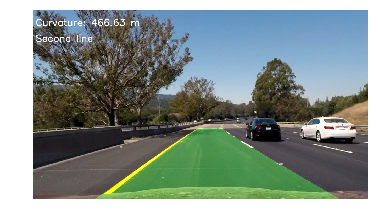

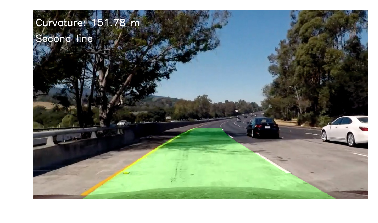

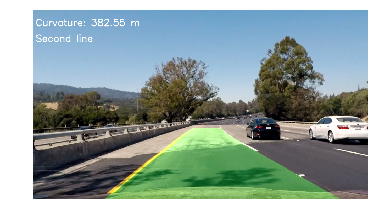

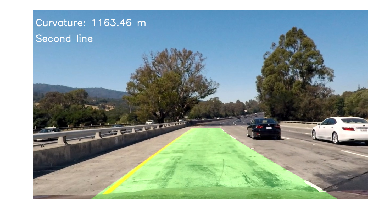

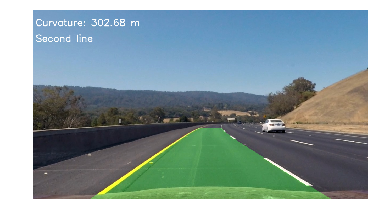

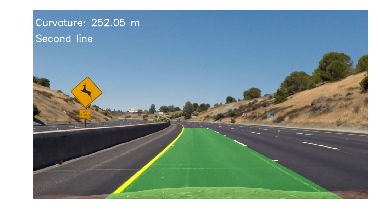

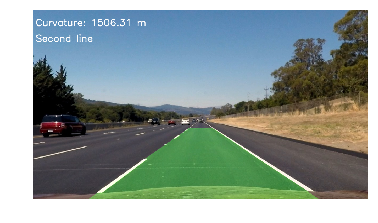

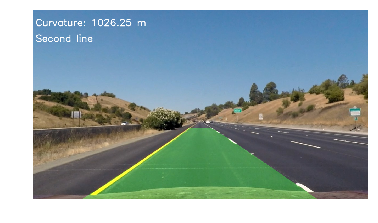

In [16]:
mx, my = lanelines.pixel_to_meter_ratios_custom()

for im in test_images_undist:

    runner.run(image=im, M=M)

    rendered_im = lanelines.render_lane(
        im, 
        runner['warped'], 
        runner['p_coefs_left'], 
        runner['p_coefs_right'], 
        Minv
    )
    
    curv = lanelines.lane_curvature(
        runner['p_coefs_left'], 
        runner['p_coefs_right'], 
        mx,
        my,
        runner['canvas_size']
    )

    im_text = 'Curvature: {:.2f} m'.format(curv)
    lanelines.put_text_on_top(rendered_im, im_text, fontscale=1.2)
    lanelines.put_text_on_top(rendered_im, 'Second line', fontscale=1.2, pos=(10, 120))
    
    plt.figure()
    plt.imshow(rendered_im)
    plt.axis('off')